In [ ]:
#!pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier

sys.path.append(os.path.abspath('../'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Структура

server2022 - основная папка, в которой храним файлы для предобработки данных, генерации признаков и пайплайн обучения модели. 

**prepare_data.py** - файл с фунциями предобработки данных

**train_val.py** - файл с пайплайном модели

**model_features.py** файл c функцими генерации признаков

In [4]:
from server2022.data.processed.prepare_data import create_df_0years_known, create_df_1year_known
from server2022.src.model_features import Feature_gen
from server2022.src.feature_importance_plot import plot_feature_importance
from server2022.src.train_val import *

# Постановка задачи 

При решении контеста мы отталкивались в первую очередь от бизнес задачи, а не от абстрактных данных.
В нашем случае бизнеса задача заключается в следующем: зная показатели некоторых компаний за прошлые годы, нужно предсказать будет ли просрочка в этом году у компаний, с которыми мы собираемся работать в этом году.
Так как в нашем распоряжении были данные только за 3 года (2019-2021) и исходя из поставленной бизнес задачи, мы можем строить следующие модели:

    1. Модель, не использующая данные о просрочке платежа компаний за прошлые года. Для каждой компании мы знаем ее финансовые показатели за последние несколько лет и, возможно, знаем факторы, подсчитанные Северсталью.
            учим на 2019; предсказываем на 2020            
            учим на 2019 и 2020; предсказываем на 2021
            
    2. Модель, использует данные компании, которая уже работала с Северсталью прошлый год. В этом случае можно использовать данные о ПДЗ за прошлый год.
        Обучение происходит на данных за 2019-2020, а тестируем на данных 2020-2021.


Других вариантов быть не может в силу поставленной бизнес задачи, так как на момент начала года мы не можем пользоваться данными ПДЗ этого года, даже для других компаний, потому что в реальной ситуации этих данных не будет! Из-за этих обстоятельств некоторые данные становятся невозможно использовать при построении моделей. Например, факторы, которые встречаются только в 2020 году, или “оценку потенциала” контрагента в 2021.

Второй момент в данных, на который хочется обратить внимание, это несбалансированность выборки. Среди компаний, представленных в 2021 году, только у 34% была просрочка, хотя для компании в 2019 и 2020 имели просрочки в 58% и 68% случаев соответственно (60% и 76%, если смотреть на 325 компаний, представленные в 2021). Отсюда встает вопрос, почему вообще такое кардинальное снижение в количестве просрочек. Либо произошло что-то существенное между этими периодами, либо данные начали собираться другим образом, вследствии чего часть просрочек “исчезла” на бумаге.

Описанные моменты сильно усложняют работу с датасетом, поэтому мы решили сосредоточится на задаче предсказания самого факта просрочки.

Также, хочется отметить, что в отличие от классических задач по машинному обучению, в нашей ситуации мы можем использовать при обучении модели данные прошлых лет компании, для которой хотим получить предсказание в этом году, так как это согласуется с бизнес задачей.

            



# Постановка ML задачи 

1) Исходя из сказанного выше **принято решения построить 2 выборки и на них обучить 2 модели**: 

  1. **Уже работали с клиентом** и есть информация, какие просрочки были при работе с ним. Для этого используется функция **create_df_1year_known**, в которой есть колонки о данных по просроченным платежам клиентов

  2. **Клиент новый** и про него нет информации, как он оплачивает. Эту выборку делаем с помощью функции **create_df_0years_known**
  
2) **Правильно построить разделение выборки на тренировочную и тестовую, чтобы не было завышения метрик модели.** 

  1. Нельзя, чтобы данные по клиенту за один год были как в обучающей, так и в тестовой выборке,  
  2. Для 1ой задачи разбить клиенов по id, и чтобы какая-то часть id вообще не попадала в обучающаю выборку, а былоа только в тесте. 
 
3) **Отобрать признаки, которые дают наибольший прирост качеству моделей**

### 1) Модель для клиентов, с которыми уже работали

In [5]:
df_known_clients = create_df_1year_known()

В обучающую выборку попадут данные по клиентам за 2020 и 2019 год, а в тестовую за 2021 год. Поскольу в данных минимальный год 2016, в фичи обучающей выборки есть возможность добавить финансовые данные только на 4 года назад(в 2020 известны за 2016). Для сохранения целостности формирования обучающей и тестовой выборки, в тестовую выборку будем добавлять тоже только данные за предыдущие 4 года, т.е. с 2017 по 2021. 

In [6]:
feat_gen = Feature_gen(-4, -1)

### описание фичей
Первоначальные запуски модели на исходных данных показали, что **наибольшую роль играют финансовые признаки**. Поэтому в модель добавляли признаки, показывающие финансовое и экономическое развитие компании: 

    1. Разница между показателями за год. Чтобы описать как динамически менялось финансовое состоянии компании,  добавили последовательно разницу между всеми годами, до текущего в выборке 
    2. Аналогично относительное изменение, т.е. эти величины не исходных единицах измерения, а в относительных, показывающее во сколько раз тот или иной показатель вырос или упал относительно прошлого года. 
    3. Относительное изменение относительно выручки. Этот признак похож на тот, что в пункте 2, но измнение показателя считается не относительно себя самого, а относительно выручки.
    
Поскольку признаки стали иметь очень разный масштаю, для них была **применена нормировка MinMaxScaler()**

In [7]:
df_known_clients = feat_gen.preprocessing_before_fitting(df_known_clients)

**Для обучения и предсказания были использованы следующие модели:**

    1) Catboost
    2) Random Forest
    3) Logistic Regression 
    
Сопостовимые результаты показывали Catboost и Random Forest, и мы выбрали **Catboost** как финальную модель, поскольку его результаты были чуть лучше.

In [8]:
def catboost_fit_predict(df, comment=''):
    model = CatBoostClassifier(iterations=500,
                               depth=5, 
                               l2_leaf_reg=5, 
                               learning_rate=0.01433,
                               loss_function='Logloss',
                               use_best_model=False,
                               eval_metric='AUC',
                               verbose=False,
                               class_weights=[1, 0.0006],
                               random_seed=RANDOM_STATE,
                              )

    make_report(model, df, treshold=0.5, to_file=False);

    X_train, X_test, y_train, y_test = data_split(df)
    probas = model.predict_proba(X_test)[:, 1]

    best = 0
    xx = 0
    for x in sorted(probas):
        pr = precision_score(y_test, probas >= x)
        rl = recall_score(y_test, probas >= x)
        cur = f1_score(y_test, probas >= x)
        if cur >= best:
            best = cur
            xx = x

    make_report(model, df, treshold=xx, to_file=True, file_path='../reports/report.csv', comment=comment)
    
    return model

Fitting model <catboost.core.CatBoostClassifier object at 0x00000249EA6DBF40> with treshold = 0.5...


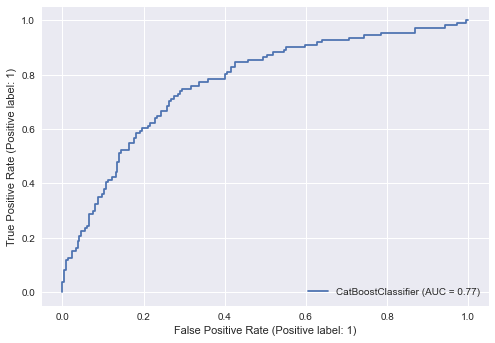

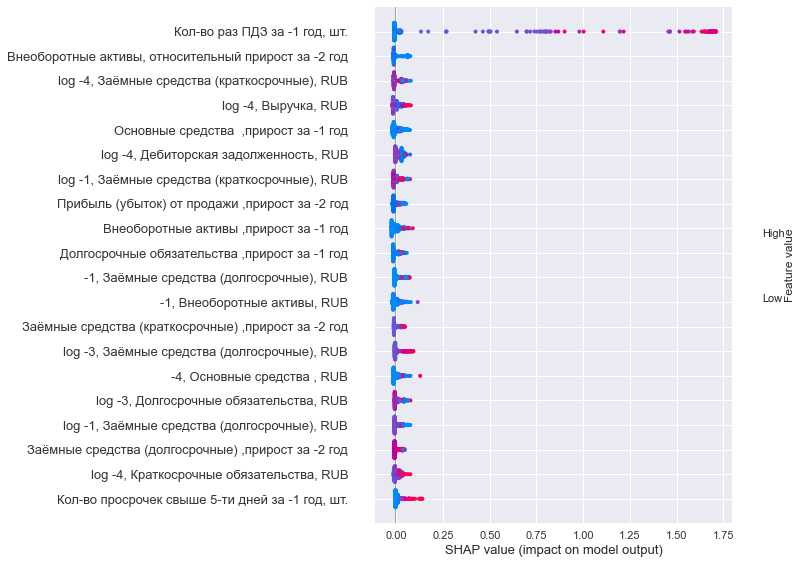

F1 = 0.0, Precision = 0.0, Recall = 0.0, Accuracy = 0.6585, ROC_AUC = 0.7696
Fitting model <catboost.core.CatBoostClassifier object at 0x00000249EA6DBF40> with treshold = 0.0...


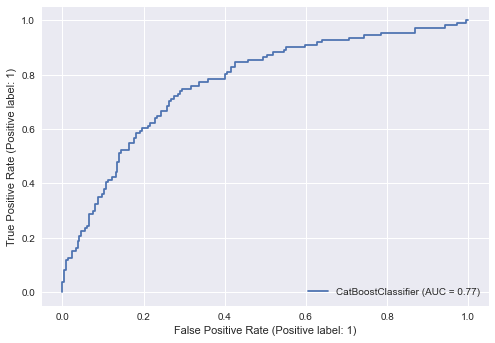

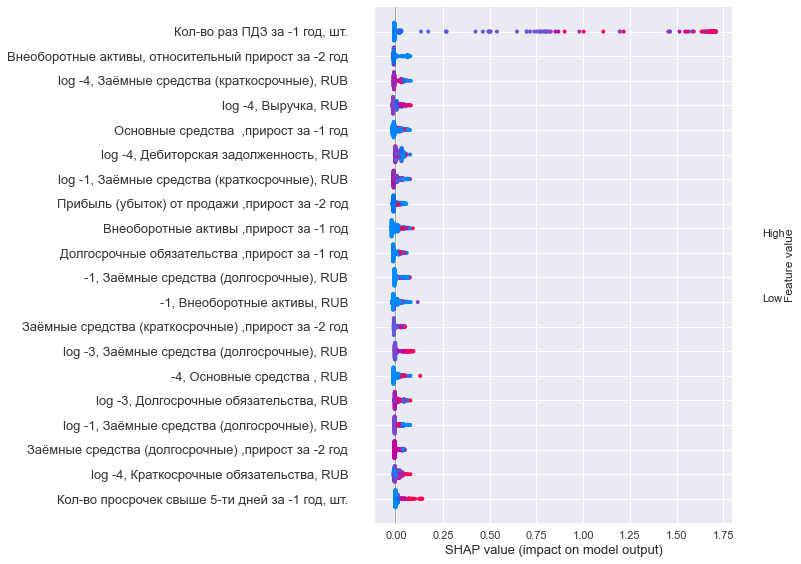

F1 = 0.6459, Precision = 0.5685, Recall = 0.7477, Accuracy = 0.72, ROC_AUC = 0.7696


In [9]:
fitted_model_known = catboost_fit_predict(df_known_clients)

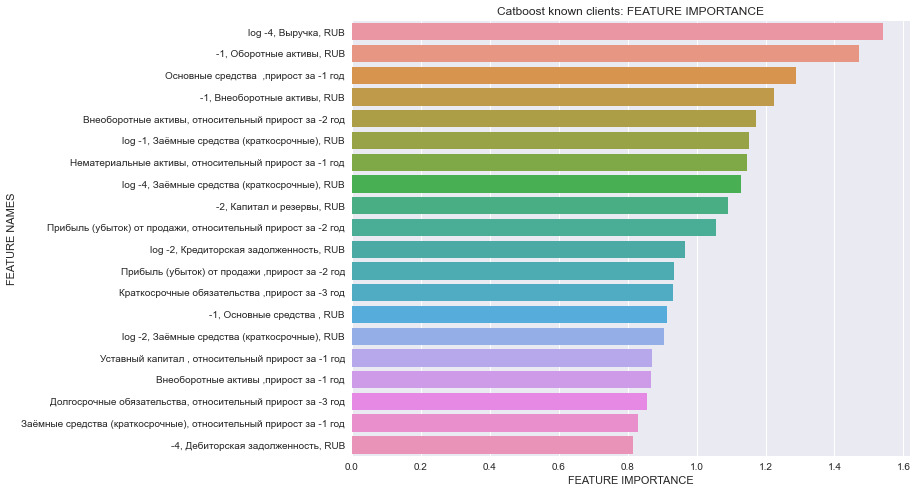

In [10]:
X_train, X_test, y_train, y_test = data_split(df_known_clients)
feature_importance = fitted_model_known.get_feature_importance()
column_name = X_train.columns

plot_feature_importance(feature_importance, column_name, "Catboost known clients: ")

### 2) Модель для клиентов, с которыми раньше не работали 

Обучающая выборка - клиенты в 2019 и 2020 году, тестовая 2021 год. В данной постановке задачи не будем знать информацию по просрочкам клиентов, то есть даже если сотрудничали с клиентом в 2019 и 2020 году, **не будем добавлять в признаки информацию о просрочке платежа.**

In [11]:
df_unknown_clients = create_df_0years_known()

**Будут использоваться такие же фичи по финансовым показателям, как и в предыдущей модели.**

In [12]:
df_unknown_clients = feat_gen.preprocessing_before_fitting(df_unknown_clients)

Fitting model <catboost.core.CatBoostClassifier object at 0x00000249EA6D6D30> with treshold = 0.5...


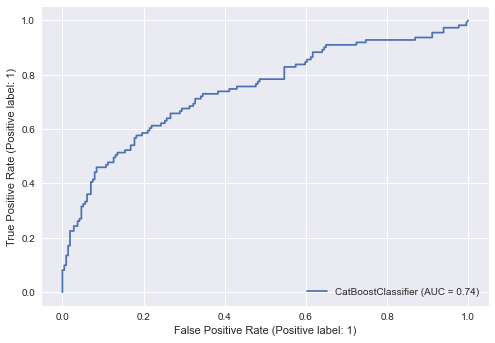

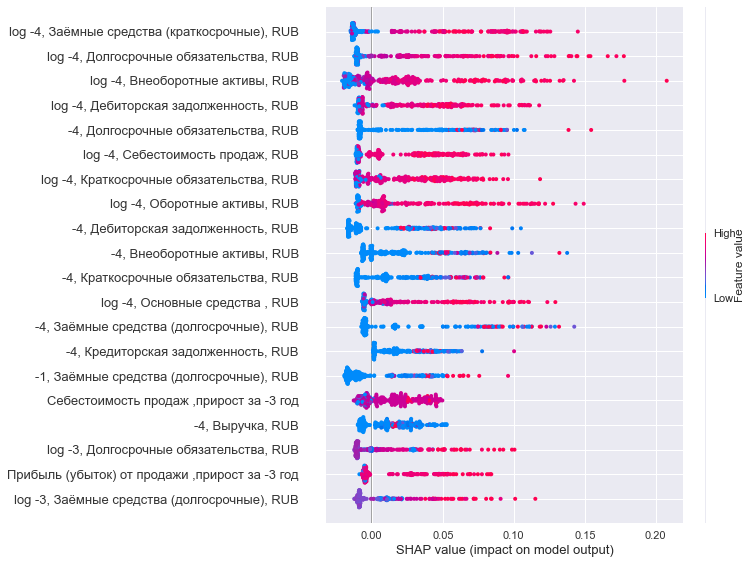

F1 = 0.0, Precision = 0.0, Recall = 0.0, Accuracy = 0.6585, ROC_AUC = 0.7447
Fitting model <catboost.core.CatBoostClassifier object at 0x00000249EA6D6D30> with treshold = 0.0...


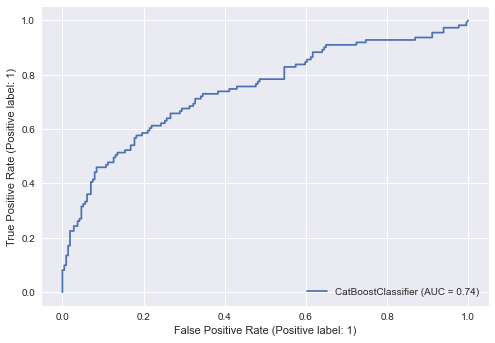

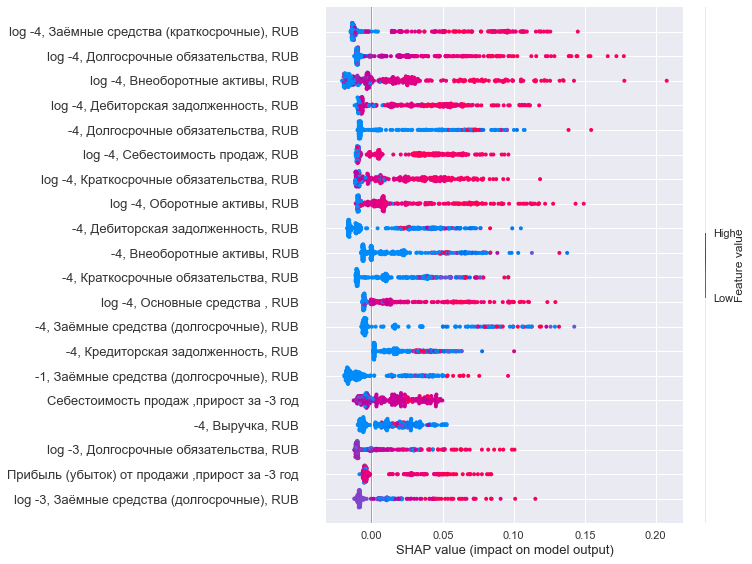

F1 = 0.609, Precision = 0.5226, Recall = 0.7297, Accuracy = 0.68, ROC_AUC = 0.7447


In [13]:
fitted_model_unknown = catboost_fit_predict(df_unknown_clients)

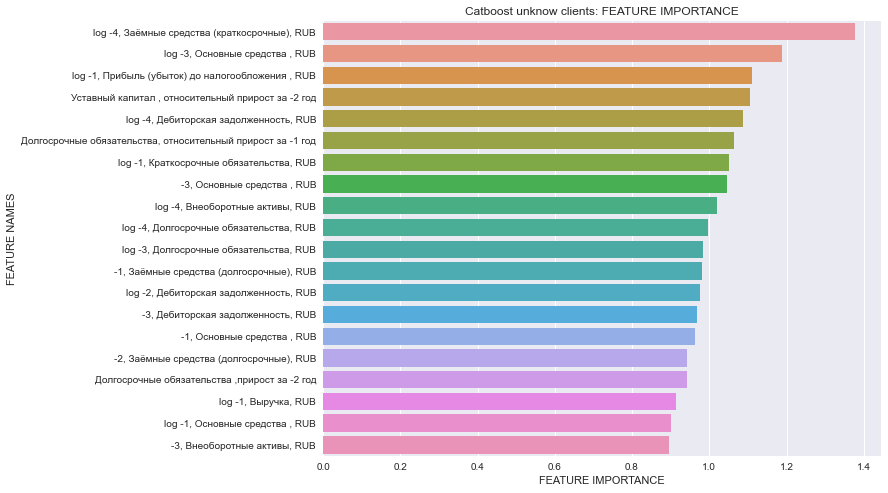

In [14]:
X_train, X_test, y_train, y_test = data_split(df_unknown_clients)
feature_importance = fitted_model_unknown.get_feature_importance()
column_name = X_train.columns

plot_feature_importance(feature_importance, column_name, "Catboost unknow clients: ")

# Вывод

В обоих моделях получили приемлемый результат по метрики **ROC_AUC(0.73-0.74)**, но не очень хороший по метрике **Accuracy(0.6)**. 

Посмотрев дополнительно  на Precision, Recall и F1-score, видно, что наша **модель предсказывает слишком много 
значений 1**, то есть что у компании будет просрочка. Это можно связать с тем, что в **обучающей и тестовой выборке разное распредление таргета**.

Мы боролись с этим с помощью гиперпараметра **class_weights модели catboost**, и получили результаты описанные выше.


Что касается признаков, смотря с помощью библиотеки shap и встроенной в catboost, прогнозируемо получили, что **историческая информация очень важна для по модели и признаки по прошлым ПДЗ имеют существенный вес. Также много именно преобразованных финансовых показателей имеют значительный вес, посколько модели проще с ними работать, чем с исходными абсолютными показателями.** 